In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tens

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from tensorflow.keras.utils import image_dataset_from_directory

import google.protobuf
print("protobuf:", google.protobuf.__version__)
print("tensorflow:", tf.__version__)

2025-11-30 00:10:47.205954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764461447.383041      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764461447.442654      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


protobuf: 3.20.3
tensorflow: 2.18.0


In [3]:
training_set = image_dataset_from_directory(
    '/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 76515 files belonging to 4 classes.


I0000 00:00:1764461563.781805      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [4]:
validation_set = image_dataset_from_directory(
    '/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/val',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 21861 files belonging to 4 classes.


In [5]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [6]:
INPUT_SHAPE = (224, 224, 3)

In [7]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=INPUT_SHAPE,
    include_top=True,
    weights="imagenet",
    include_preprocessing=True,
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)


29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
#base_model.trainable = False  # -- used to freeze weights of this pretrained model

In [9]:
model = tf.keras.models.Sequential()

In [10]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [11]:
model.add(base_model)

In [12]:
model.add(tf.keras.layers.Dense(units = 4,activation='softmax'))

In [13]:
metrics_list = ['accuracy',
                tf.keras.metrics.F1Score()]

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=metrics_list)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1000)           │     7,200,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,204,316 (27.48 MB)

 Trainable params: 7,143,708 (27.25 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [16]:
training_history = model.fit(x=training_set,validation_data=validation_set,epochs=15)

Epoch 1/15


I0000 00:00:1764461656.755609     118 service.cc:148] XLA service 0x7dd54c002ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764461656.756207     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764461662.407140     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1764461671.695182     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764461671.881531     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764461672.359277     118 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764461672.5662

   1/2392 ━━━━━━━━━━━━━━━━━━━━ 63:13:59 95s/step - accuracy: 0.4375 - f1_score: 0.3030 - loss: 1.3855

I0000 00:00:1764461692.722883     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2392/2392 ━━━━━━━━━━━━━━━━━━━━ 384s 121ms/step - accuracy: 0.7844 - f1_score: 0.4324 - loss: 1.2328 - val_accuracy: 0.8067 - val_f1_score: 0.4449 - val_loss: 0.9748
Epoch 2/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 232s 97ms/step - accuracy: 0.8376 - f1_score: 0.5529 - loss: 0.9105 - val_accuracy: 0.9014 - val_f1_score: 0.7059 - val_loss: 0.7169
Epoch 3/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 231s 97ms/step - accuracy: 0.9200 - f1_score: 0.7963 - loss: 0.6708 - val_accuracy: 0.9668 - val_f1_score: 0.9399 - val_loss: 0.5415
Epoch 4/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 231s 97ms/step - accuracy: 0.9663 - f1_score: 0.9402 - loss: 0.5083 - val_accuracy: 0.9694 - val_f1_score: 0.9469 - val_loss: 0.4144
Epoch 5/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 231s 96ms/step - accuracy: 0.9700 - f1_score: 0.9468 - loss: 0.3913 - val_accuracy: 0.9632 - val_f1_score: 0.9371 - val_loss: 0.3375
Epoch 6/15
2392/2392 ━━━━━━━━━━━━━━━━━━━━ 231s 96ms/step - accuracy: 0.9740 - f1_score: 0.9541 - loss: 0.3000 - val_accuracy: 0.9733 - 

In [17]:
model.save("Trained_Model_EfficientNetV2B0.h5")

In [18]:
model.save("Trained_Model_EfficientNetV2B0.keras")

In [19]:
# Saving history
with open('Training_history_EfficientNetV2B0.pkl', 'wb') as f:
    pickle.dump(training_history.history, f)


In [20]:
# Reloading History from pickle
with open('Training_history_EfficientNetV2B0.pkl', 'rb') as f:
    load_history = pickle.load(f)
load_history


{'accuracy': [0.8011108636856079,
  0.869110643863678,
  0.9429000616073608,
  0.9675750136375427,
  0.9722537994384766,
  0.9755734205245972,
  0.9793243408203125,
  0.9816245436668396,
  0.9834019541740417,
  0.9860027432441711,
  0.987427294254303,
  0.9884728193283081,
  0.9900542497634888,
  0.9904201626777649,
  0.9910867214202881],
 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=
  array([8.8308352e-01, 2.4609306e-04, 0.0000000e+00, 8.8447601e-01],
        dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9263934 , 0.75708133, 0.        , 0.91699547], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9554818, 0.9434549, 0.6721066, 0.9706602], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9712064 , 0.95659184, 0.85824186, 0.9858882 ], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9758776 , 0.9645803 , 0.87688804, 0.98760974], dtype=float32)>,
  <tf.Tensor: shape=(4,), dt

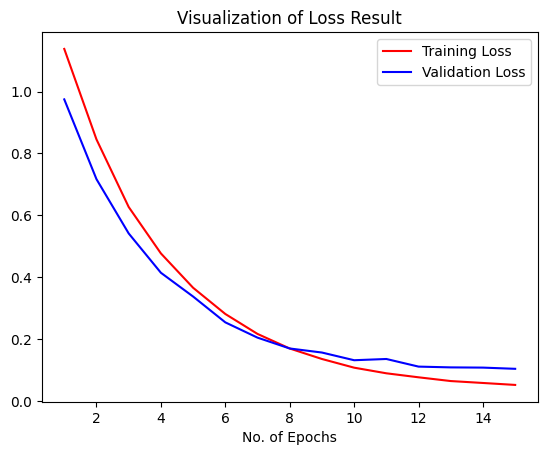

In [21]:
#Loss Visualization
epochs = [i for i in range(1,16)]
plt.plot(epochs,load_history['loss'],color='red',label='Training Loss')
plt.plot(epochs,load_history['val_loss'],color='blue',label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()

In [22]:
test_set = validation_set = image_dataset_from_directory(
    '/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 10933 files belonging to 4 classes.


In [23]:
test_loss,test_acc,f1_score = model.evaluate(test_set)

171/171 ━━━━━━━━━━━━━━━━━━━━ 33s 163ms/step - accuracy: 0.9741 - f1_score: 0.9540 - loss: 0.1095


In [24]:
test_loss

0.10699795186519623

In [25]:
test_acc

0.975029706954956

In [26]:
f1_score

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9791611 , 0.96695644, 0.89066964, 0.98809636], dtype=float32)>

## Model Evaluation

In [27]:
model = tf.keras.models.load_model("Trained_Model_EfficientNetV2B0.h5")

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1000)           │     7,200,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,204,318 (27.48 MB)

 Trainable params: 7,143,708 (27.25 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 2 (12.00 B)

In [29]:
test_set = validation_set = image_dataset_from_directory(
    '/kaggle/input/labeled-optical-coherence-tomography-oct/Dataset - train+val+test/test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 10933 files belonging to 4 classes.


In [30]:
##Computing True labels from test set
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [31]:
Y_true

<tf.Tensor: shape=(10933,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

In [32]:
##Computing Predicted labels using test set
predicted_categories = model.predict(test_set)
Y_pred = tf.argmax(predicted_categories, axis=1)

171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step


In [33]:
Y_true

<tf.Tensor: shape=(10933,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

In [34]:
Y_pred

<tf.Tensor: shape=(10933,), dtype=int64, numpy=array([0, 0, 0, ..., 3, 3, 3])>

### 1. Classification Report

In [35]:
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3746
           1       0.98      0.96      0.97      1161
           2       0.90      0.88      0.89       887
           3       0.98      0.99      0.99      5139

    accuracy                           0.98     10933
   macro avg       0.96      0.95      0.96     10933
weighted avg       0.97      0.98      0.97     10933



### 2. Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_true,Y_pred)
cm

array([[3665,   12,   64,    5],
       [  12, 1112,    2,   35],
       [  56,    4,  778,   49],
       [   7,   11,   16, 5105]])

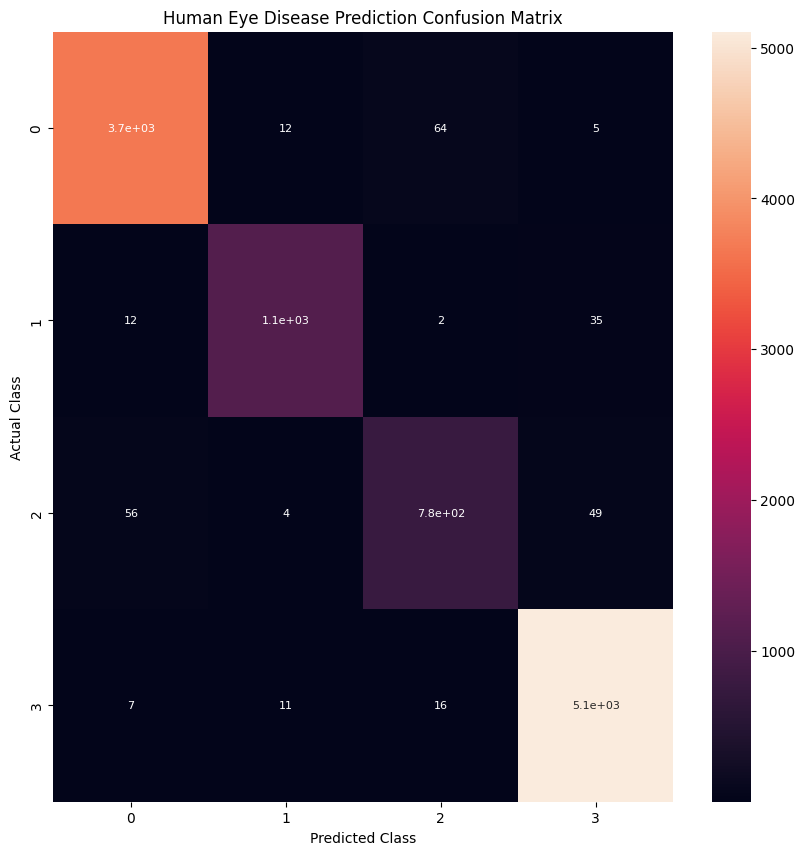

In [37]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,annot_kws={"size":8})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Human Eye Disease Prediction Confusion Matrix",fontsize=12)
plt.show()

Các metric trong load_history: ['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss']


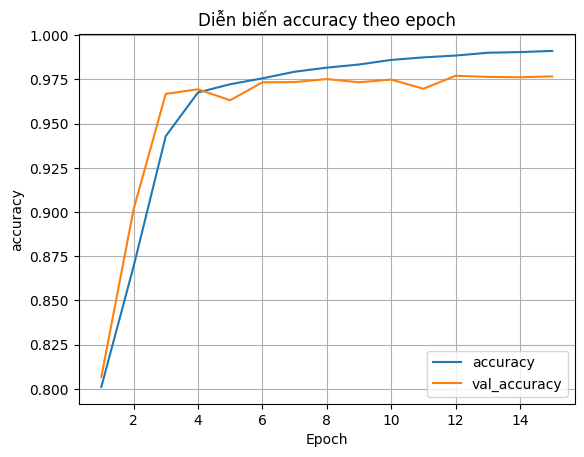

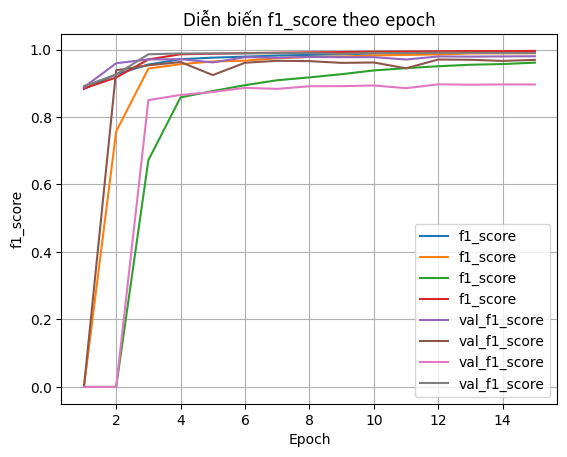

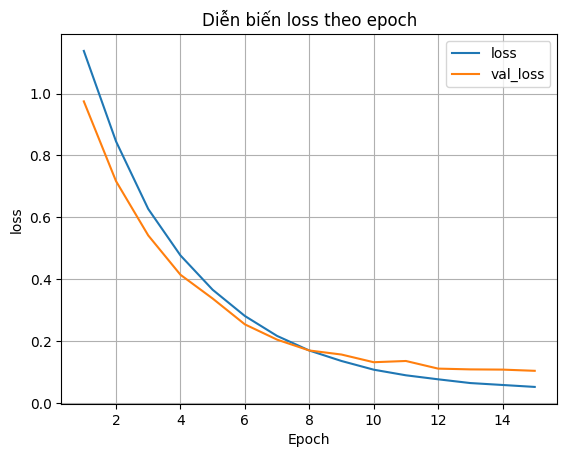

In [38]:
# ===== Thêm các biểu đồ từ lịch sử huấn luyện =====
import matplotlib.pyplot as plt

# Xem các metric có trong load_history
print("Các metric trong load_history:", list(load_history.keys()))

# Tự động vẽ tất cả các metric train/val nếu có
for key in load_history.keys():
    # Bỏ qua các key bắt đầu bằng 'val_'
    if key.startswith('val_'):
        continue

    train_key = key
    val_key = 'val_' + key

    values = load_history[train_key]
    if not isinstance(values, (list, tuple)):
        continue
    if len(values) <= 1:
        continue

    epochs = range(1, len(values) + 1)

    plt.figure()
    plt.plot(epochs, load_history[train_key], label=train_key)
    if val_key in load_history:
        plt.plot(epochs, load_history[val_key], label=val_key)
    plt.xlabel("Epoch")
    plt.ylabel(train_key)
    plt.title(f"Diễn biến {train_key} theo epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


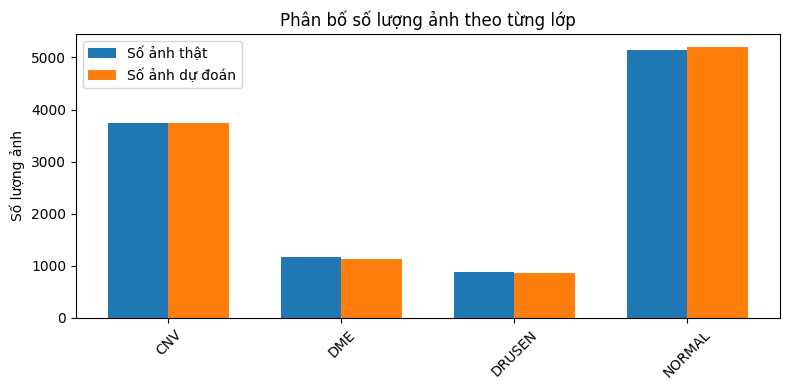

In [39]:
# ===== Phân bố số lượng ảnh theo lớp (nhãn thật & dự đoán) =====
import numpy as np
import matplotlib.pyplot as plt

# Chuyển về numpy
y_true_np = Y_true.numpy()
y_pred_np = Y_pred.numpy()

# Lấy tên lớp
if hasattr(test_set, 'class_names'):
    class_names = test_set.class_names
else:
    num_classes = int(max(y_true_np.max(), y_pred_np.max()) + 1)
    class_names = [str(i) for i in range(num_classes)]

num_classes = len(class_names)

true_counts = np.bincount(y_true_np, minlength=num_classes)
pred_counts = np.bincount(y_pred_np, minlength=num_classes)

indices = np.arange(num_classes)
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(indices - width/2, true_counts, width=width, label="Số ảnh thật")
plt.bar(indices + width/2, pred_counts, width=width, label="Số ảnh dự đoán")
plt.xticks(indices, class_names, rotation=45)
plt.ylabel("Số lượng ảnh")
plt.title("Phân bố số lượng ảnh theo từng lớp")
plt.legend()
plt.tight_layout()
plt.show()


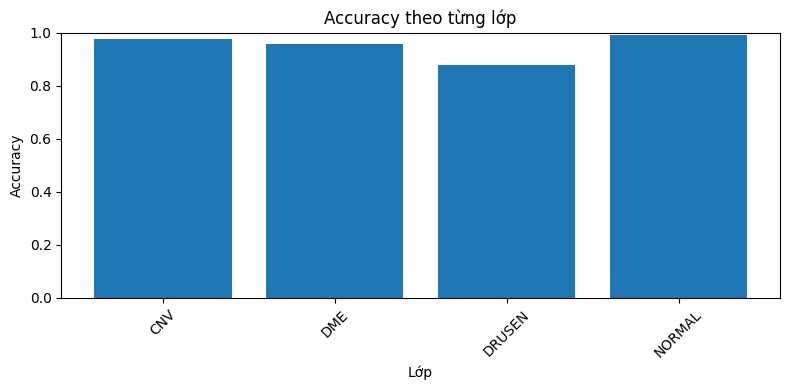

In [40]:
# ===== Độ chính xác theo từng lớp từ Confusion Matrix =====
import numpy as np
import matplotlib.pyplot as plt

# Đảm bảo đã có ma trận nhầm lẫn cm
if "cm" not in globals():
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(Y_true, Y_pred)

# Lấy tên lớp
if hasattr(test_set, 'class_names'):
    class_names = test_set.class_names
else:
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]

correct_per_class = np.diag(cm)
samples_per_class = cm.sum(axis=1)
per_class_acc = correct_per_class / samples_per_class
per_class_acc = np.nan_to_num(per_class_acc)

plt.figure(figsize=(8, 4))
plt.bar(class_names, per_class_acc)
plt.ylim(0, 1)
plt.xlabel("Lớp")
plt.ylabel("Accuracy")
plt.title("Accuracy theo từng lớp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


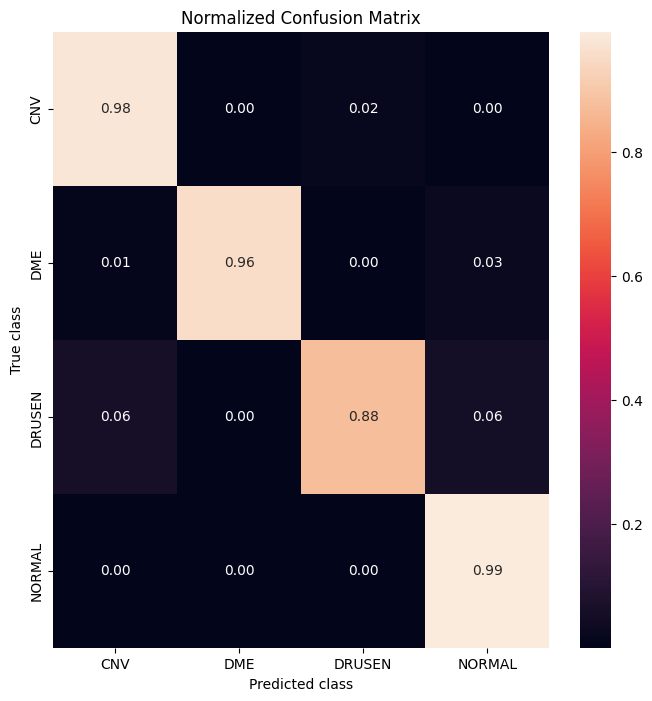

In [41]:
# ===== Ma trận nhầm lẫn chuẩn hoá theo từng lớp =====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đảm bảo đã có ma trận nhầm lẫn cm
if "cm" not in globals():
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(Y_true, Y_pred)

row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = cm.astype("float") / row_sums
cm_norm = np.nan_to_num(cm_norm)

# Lấy tên lớp
if hasattr(test_set, 'class_names'):
    class_names = test_set.class_names
else:
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]

plt.figure(figsize=(8, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Normalized Confusion Matrix")
plt.show()


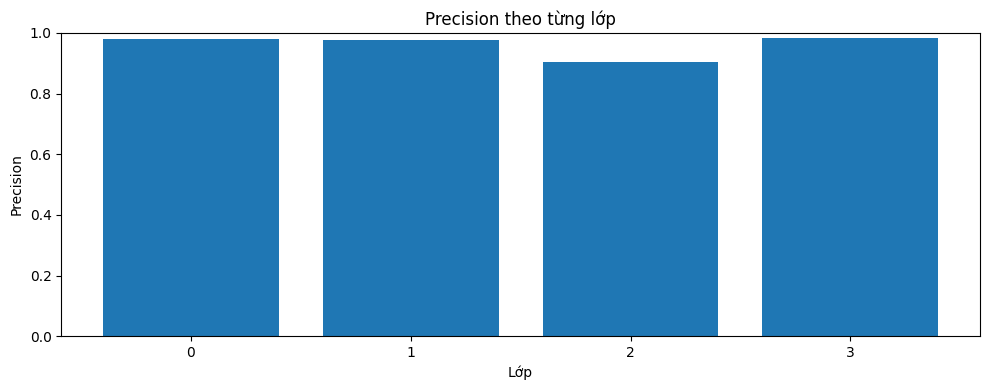

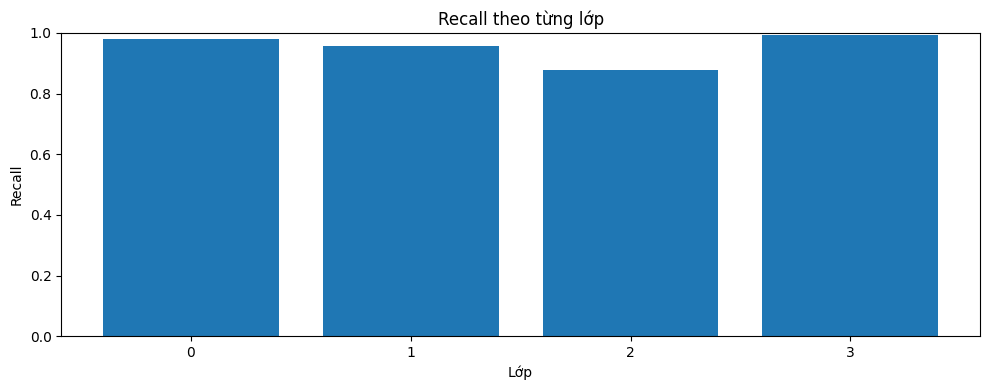

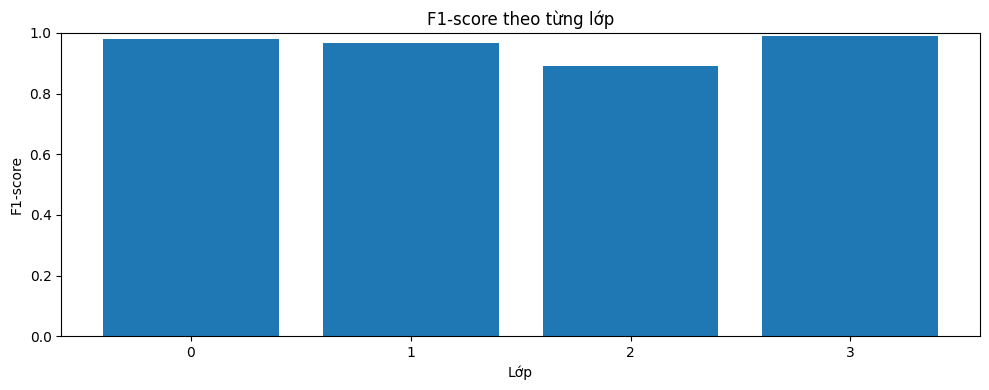

,precision,recall,f1-score,support
0,0.979947,0.978377,0.979161,3746.0
1,0.976295,0.957795,0.966957,1161.0
2,0.904651,0.877114,0.890670,887.0
3,0.982865,0.993384,0.988096,5139.0


In [42]:
# ===== Precision, Recall, F1-score theo từng lớp =====
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report_dict = classification_report(Y_true, Y_pred, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()

# Chỉ lấy các dòng tương ứng với từng lớp (thường là '0','1',...)
class_mask = df_report.index.str.isnumeric()
df_classes = df_report[class_mask]

# Precision
plt.figure(figsize=(10, 4))
plt.bar(df_classes.index, df_classes["precision"])
plt.ylim(0, 1)
plt.xlabel("Lớp")
plt.ylabel("Precision")
plt.title("Precision theo từng lớp")
plt.tight_layout()
plt.show()

# Recall
plt.figure(figsize=(10, 4))
plt.bar(df_classes.index, df_classes["recall"])
plt.ylim(0, 1)
plt.xlabel("Lớp")
plt.ylabel("Recall")
plt.title("Recall theo từng lớp")
plt.tight_layout()
plt.show()

# F1-score
plt.figure(figsize=(10, 4))
plt.bar(df_classes.index, df_classes["f1-score"])
plt.ylim(0, 1)
plt.xlabel("Lớp")
plt.ylabel("F1-score")
plt.title("F1-score theo từng lớp")
plt.tight_layout()
plt.show()

df_classes  # Bảng số liệu chi tiết cho từng lớp


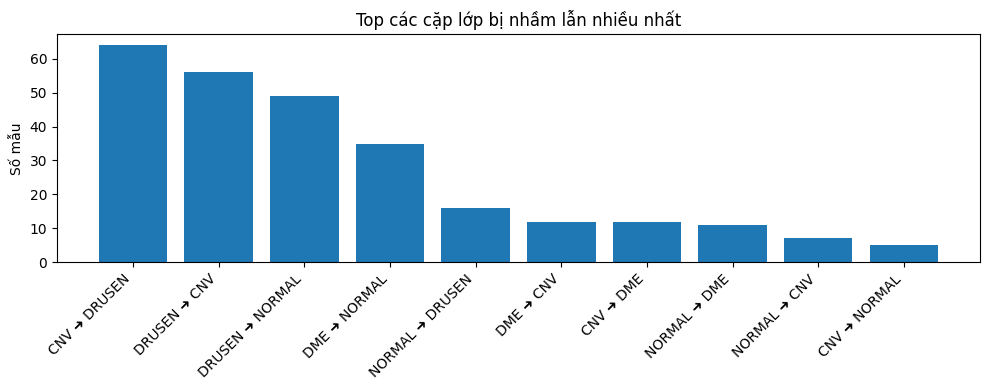

In [43]:
# ===== Các cặp lớp bị nhầm lẫn nhiều nhất =====
import numpy as np
import matplotlib.pyplot as plt

# Đảm bảo đã có ma trận nhầm lẫn cm
if "cm" not in globals():
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(Y_true, Y_pred)

# Lấy tên lớp
if hasattr(test_set, 'class_names'):
    class_names = test_set.class_names
else:
    num_classes = cm.shape[0]
    class_names = [str(i) for i in range(num_classes)]

pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            continue
        count = cm[i, j]
        if count > 0:
            pairs.append((count, i, j))

pairs.sort(reverse=True)
top_k = pairs[:10]

labels = [f"{class_names[i]} ➜ {class_names[j]}" for (count, i, j) in top_k]
values = [count for (count, i, j) in top_k]

plt.figure(figsize=(10, 4))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45, ha="right")
plt.ylabel("Số mẫu")
plt.title("Top các cặp lớp bị nhầm lẫn nhiều nhất")
plt.tight_layout()
plt.show()


Số lượng mẫu dự đoán sai: 273


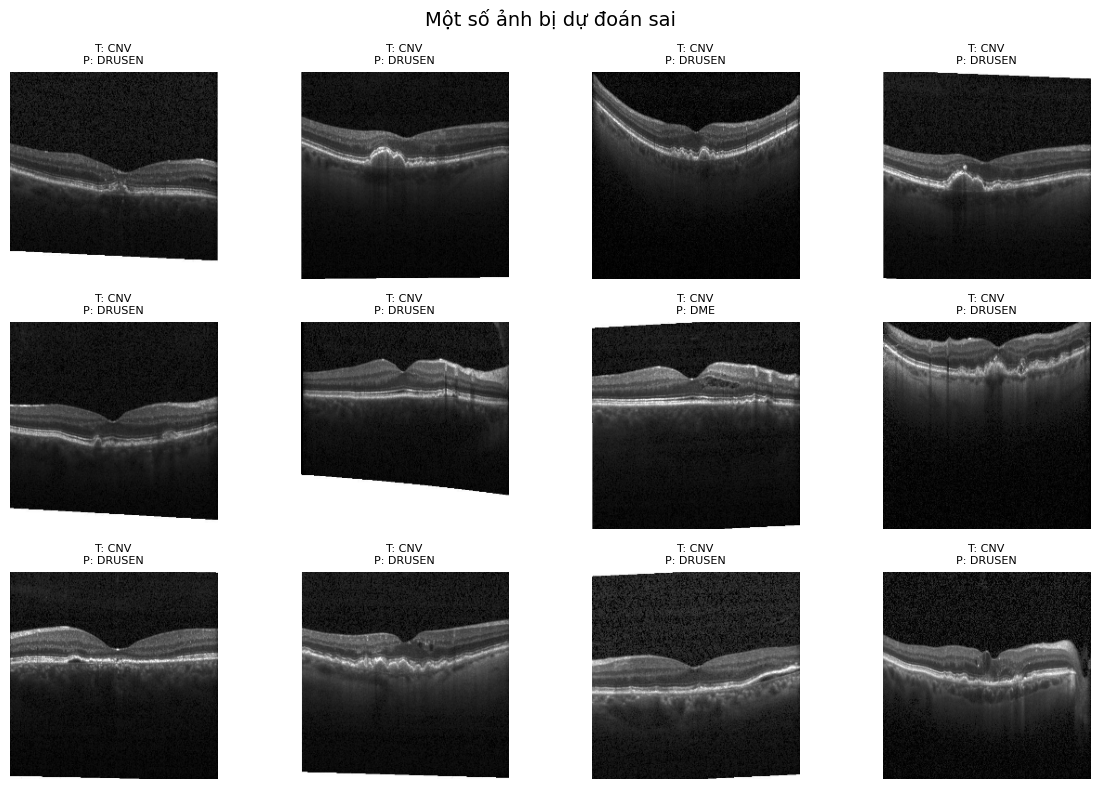

In [44]:
# ===== Hiển thị một số ảnh bị dự đoán sai =====
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Đảm bảo có y_true_np, y_pred_np
if "y_true_np" not in globals() or "y_pred_np" not in globals():
    y_true_np = Y_true.numpy()
    y_pred_np = Y_pred.numpy()

# Lấy tên lớp
if "class_names" not in globals():
    if hasattr(test_set, 'class_names'):
        class_names = test_set.class_names
    else:
        num_classes = int(max(y_true_np.max(), y_pred_np.max()) + 1)
        class_names = [str(i) for i in range(num_classes)]

# Gom tất cả ảnh & nhãn thật từ test_set
images = []
labels_true = []
for batch_images, batch_labels in test_set:
    images.append(batch_images)
    labels_true.append(batch_labels)

images = tf.concat(images, axis=0)
labels_true = tf.argmax(tf.concat(labels_true, axis=0), axis=1).numpy()

mis_idx = np.where(labels_true != y_pred_np)[0]
print("Số lượng mẫu dự đoán sai:", len(mis_idx))

n_show = min(12, len(mis_idx))
plt.figure(figsize=(12, 8))
for i in range(n_show):
    idx = mis_idx[i]
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    true_label = class_names[labels_true[idx]]
    pred_label = class_names[y_pred_np[idx]]
    plt.title(f"T: {true_label}\nP: {pred_label}", fontsize=8)
    plt.axis("off")

plt.suptitle("Một số ảnh bị dự đoán sai", fontsize=14)
plt.tight_layout()
plt.show()
